# Machine Learning with Spark 
---

## 1. Data preparation

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.max_columns = 50

import warnings
warnings.filterwarnings("ignore")

In [2]:
from pyspark.sql import SparkSession

from pyspark.sql.functions import *
#from pyspark.sql.functions import lit, col
from pyspark.sql.types import DoubleType

Let's see what our dataset looks like

In [3]:
# creation of a spark session
spk_sess = SparkSession \
    .builder \
    .appName("_Project_Spark_App") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

# load csv file in a DF and show first lines
df = spk_sess.read.csv("./solar_generation_by_station.csv", header=True, sep=",");
df.select('time_step', 'AT11', 'AT12').show(10)

+---------+-------+-------------------+
|time_step|   AT11|               AT12|
+---------+-------+-------------------+
|        1|    0.0|                0.0|
|        2|    0.0|                0.0|
|        3|    0.0|                0.0|
|        4|    0.0|                0.0|
|        5|    0.0|                0.0|
|        6|    0.0|                0.0|
|        7|    0.0|                0.0|
|        8|    0.0|                0.0|
|        9|0.13127|0.08148999999999999|
|       10| 0.1259|             0.1032|
+---------+-------+-------------------+
only showing top 10 rows



Creation of a dataframe with time step corresponding to measures in our DF

In [4]:
def generate_series(start, stop, interval):
    """
    :param start  - lower bound, inclusive
    :param stop   - upper bound, exclusive
    :interval int - increment interval in seconds
    """

    # Determine start and stops in epoch seconds
    start, stop = spk_sess.createDataFrame([(start, stop)], ("start", "stop")) \
                        .select([col(c).cast("timestamp") \
                        .cast("long") for c in ("start", "stop")]) \
                        .first()
    # Create range with increments and cast to timestamp
    return spk_sess.range(start, stop, interval) \
                .select(col("id").cast("timestamp").alias("value"))


# credits : https://stackoverflow.com/questions/43141671/sparksql-on-pyspark-how-to-generate-time-series
dt_gen = generate_series("1986-01-01", "2016-01-01", 60 * 60) # By hour, by day use 60 * 60 * 24

# from pyspark.sql.functions import monotonically_increasing_id
# The generated ID is guaranteed to be monotonically increasing and unique, but not consecutive :
# dt_gen = dt_gen.withColumn("index", monotonically_increasing_id())
# an other solution consist in dt_gen = dt_gen.withColumn('index', row_number()) or with zipWithIndex()
pandas_df = dt_gen.toPandas()
pandas_df['idx'] = pandas_df.index +1
dt_gen = spk_sess.createDataFrame(pandas_df)

del pandas_df
dt_gen.show(5)

+-------------------+---+
|              value|idx|
+-------------------+---+
|1986-01-01 00:00:00|  1|
|1986-01-01 01:00:00|  2|
|1986-01-01 02:00:00|  3|
|1986-01-01 03:00:00|  4|
|1986-01-01 04:00:00|  5|
+-------------------+---+
only showing top 5 rows



In [5]:
# other solution
#from pyspark.sql.functions import sequence, to_date, explode, col
spk_sess.sql("SELECT sequence(to_date('1986-01-01'), to_date('2016-01-01'), INTERVAL 1 DAY) as date").withColumn("date", explode(col("date"))) #.show(5)

DataFrame[date: date]

Let's verify the 2 DF have the same lenght, then join them

In [6]:
df.count(), dt_gen.count()

(262968, 262968)

In [7]:
dt_gen.sort(desc("value")).show(5)

+-------------------+------+
|              value|   idx|
+-------------------+------+
|2015-12-31 23:00:00|262968|
|2015-12-31 22:00:00|262967|
|2015-12-31 21:00:00|262966|
|2015-12-31 20:00:00|262965|
|2015-12-31 19:00:00|262964|
|2015-12-31 18:00:00|262963|
|2015-12-31 17:00:00|262962|
|2015-12-31 16:00:00|262961|
|2015-12-31 15:00:00|262960|
|2015-12-31 14:00:00|262959|
+-------------------+------+
only showing top 10 rows



In [8]:
df = df.join(dt_gen, df.time_step == dt_gen.idx)
df.select('time_step', 'idx', 'value', 'AT11', 'AT12', 'FR10').show(10)

+---------+---+-------------------+--------------------+-------------------+--------------------+
|time_step|idx|              value|                AT11|               AT12|                FR10|
+---------+---+-------------------+--------------------+-------------------+--------------------+
|        1|  1|1986-01-01 00:00:00|                 0.0|                0.0|                 0.0|
|        2|  2|1986-01-01 01:00:00|                 0.0|                0.0|                 0.0|
|        3|  3|1986-01-01 02:00:00|                 0.0|                0.0|                 0.0|
|        4|  4|1986-01-01 03:00:00|                 0.0|                0.0|                 0.0|
|        5|  5|1986-01-01 04:00:00|                 0.0|                0.0|                 0.0|
|        6|  6|1986-01-01 05:00:00|                 0.0|                0.0|                 0.0|
|        7|  7|1986-01-01 06:00:00|                 0.0|                0.0|                 0.0|
|        8|  8|1986-

In [9]:
# drop useless cols
df = df.drop('time_step', 'index')

# keep only columns relatives to france
col_fr = [c for c in df.columns if 'FR' in c]
col_fr.append('value')
df = df.select(col_fr)

In [10]:
# rename the time_step col
df = df.withColumnRenamed("value", "date_time")

# change cols types
for c in df.columns:
    if c != 'date_time':
        df = df.withColumn(c, df[c].cast(DoubleType()))

In [11]:
# df.printSchema()
df.dtypes[-3:]

[('FR82', 'double'), ('FR71', 'double'), ('date_time', 'timestamp')]

There isn't any missing values :

In [12]:
#from pyspark.sql.functions import isnan, when, count, col

df.select([count(when(isnan(c), c)).alias(c) for c in df.columns if c != 'date_time']).show()

+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
|FR42|FR61|FR72|FR25|FR26|FR52|FR24|FR21|FR83|FR43|FR23|FR10|FR81|FR63|FR41|FR62|FR30|FR51|FR22|FR53|FR82|FR71|
+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|
+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+



In [13]:
# drop na values if needed / not the case here
df = df.na.drop()

In the case of NaNs, here is a usefull link to [deal with missing values](https://fr.coursera.org/lecture/big-data-machine-learning/handling-missing-values-in-spark-Goh1z). Now, we've to add few columns with the date time infos.

In [14]:
df = df.withColumn("month", month(df.date_time).alias('month')) \
    .withColumn("day_of_year", dayofyear(df.date_time).alias('day_of_year')) \
    .withColumn("hour", hour(df.date_time).alias('hour'))

df.select('FR42', 'date_time', 'month', 'day_of_year', 'hour').show(40)

+--------------------+-------------------+-----+-----------+----+
|                FR42|          date_time|month|day_of_year|hour|
+--------------------+-------------------+-----+-----------+----+
|                 0.0|1986-01-02 01:00:00|    1|          2|   1|
|                 0.0|1986-01-02 04:00:00|    1|          2|   4|
|                 0.0|1986-01-20 17:00:00|    1|         20|  17|
|                 0.0|1986-02-10 03:00:00|    2|         41|   3|
|                 0.0|1986-03-11 20:00:00|    3|         70|  20|
| 0.06627000000000001|1986-03-12 16:00:00|    3|         71|  16|
|                 0.0|1986-03-17 05:00:00|    3|         76|   5|
|                 0.0|1986-03-23 05:00:00|    3|         82|   5|
|                 0.0|1986-03-26 23:00:00|    3|         85|  23|
|                 0.0|1986-04-03 05:00:00|    4|         93|   5|
|             0.06895|1986-04-04 17:00:00|    4|         94|  17|
|                 0.0|1986-04-13 04:00:00|    4|        103|   4|
|         

---

# 2. Data exploration

Basic stats

In [16]:
temp_df = df.select('FR21', 'FR22', 'FR23', 'FR24', 'FR25')
temp_df.describe().show()

+-------+-------------------+-------------------+-------------------+-------------------+-------------------+
|summary|               FR21|               FR22|               FR23|               FR24|               FR25|
+-------+-------------------+-------------------+-------------------+-------------------+-------------------+
|  count|             262968|             262968|             262968|             262968|             262968|
|   mean|  0.129254813665541| 0.1259932192129841|0.12627776257947732| 0.1360888294012959|0.12797964170545473|
| stddev|0.20521503114859999|0.20127526900909207|0.20220008711163703|0.20982899870933316|0.20146804261326595|
|    min|                0.0|                0.0|                0.0|                0.0|                0.0|
|    max| 0.9166200000000001| 0.9161299999999999|            0.92315| 0.9179700000000001|            0.92156|
+-------+-------------------+-------------------+-------------------+-------------------+-------------------+



In [17]:
def pretty_summary(df):
    """ Neat summary statistics of a Spark dataframe
    Args: pyspark.sql.dataframe.DataFrame (df): input dataframe
    Returns:pandas.core.frame.DataFrame: a pandas dataframe with the summary statistics of df
    """
    temp = df.describe().toPandas()
    temp.iloc[1:3,1:] = temp.iloc[1:3,1:].convert_objects(convert_numeric=True)
    pd.options.display.float_format = '{:.2f}'.format
    return temp

pretty_summary(df.drop('date_time', 'month', 'day_of_year', 'hour'))

,summary,FR42,FR61,FR72,FR25,FR26,FR52,FR24,FR21,FR83,FR43,FR23,FR10,FR81,FR63,FR41,FR62,FR30,FR51,FR22,FR53,FR82,FR71
0,count,262968,262968,262968,262968,262968,262968,262968,262968,262968,262968,262968,262968,262968,262968,262968,262968,262968,262968,262968,262968,262968,262968
1,mean,0.13,0.15,0.14,0.13,0.14,0.13,0.14,0.13,0.17,0.13,0.13,0.13,0.16,0.14,0.13,0.15,0.12,0.14,0.13,0.14,0.17,0.15
2,stddev,0.21,0.22,0.22,0.20,0.21,0.20,0.21,0.21,0.24,0.21,0.20,0.21,0.24,0.22,0.20,0.22,0.20,0.21,0.20,0.22,0.25,0.22
3,min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,max,0.9325100000000001,0.907,0.9521,0.92156,0.9263399999999999,0.94709,0.9179700000000001,0.9166200000000001,0.9245200000000001,0.9369700000000001,0.92315,0.91125,0.94285,0.93368,0.92785,0.91659,0.93215,0.92256,0.9161299999999999,0.91776,0.9150799999999999,0.93804


Correlation matrix

In [18]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation


temp_df = df.drop('date_time', 'month', 'day_of_year', 'hour')
cols = temp_df.columns
vector_col = "corr_features"

assembler = VectorAssembler(inputCols=cols, outputCol=vector_col)
temp_df_vector = assembler.transform(temp_df).select(vector_col)
matrix = Correlation.corr(temp_df_vector, vector_col)

matrix = Correlation.corr(temp_df_vector, vector_col).collect()[0][0]
corrmatrix = matrix.toArray().tolist()

mat = spk_sess.createDataFrame(corrmatrix, cols)
corr = mat.toPandas()
corr.head()

,FR42,FR61,FR72,FR25,FR26,FR52,FR24,FR21,FR83,FR43,FR23,FR10,FR81,FR63,FR41,FR62,FR30,FR51,FR22,FR53,FR82,FR71
0,1.00,0.82,0.87,0.81,0.92,0.79,0.87,0.92,0.81,0.95,0.82,0.86,0.81,0.85,0.96,0.83,0.83,0.82,0.85,0.82,0.82,0.89
1,0.82,1.00,0.92,0.84,0.88,0.83,0.89,0.84,0.83,0.85,0.82,0.84,0.91,0.94,0.82,0.97,0.80,0.88,0.82,0.94,0.87,0.90
2,0.87,0.92,1.00,0.82,0.94,0.80,0.91,0.88,0.85,0.92,0.81,0.85,0.90,0.96,0.87,0.94,0.80,0.85,0.83,0.90,0.88,0.96
3,0.81,0.84,0.82,1.00,0.85,0.94,0.91,0.87,0.77,0.81,0.96,0.91,0.80,0.83,0.84,0.81,0.90,0.95,0.91,0.88,0.79,0.81
4,0.92,0.88,0.94,0.85,1.00,0.83,0.94,0.95,0.82,0.95,0.86,0.91,0.85,0.92,0.94,0.88,0.85,0.87,0.89,0.90,0.85,0.93


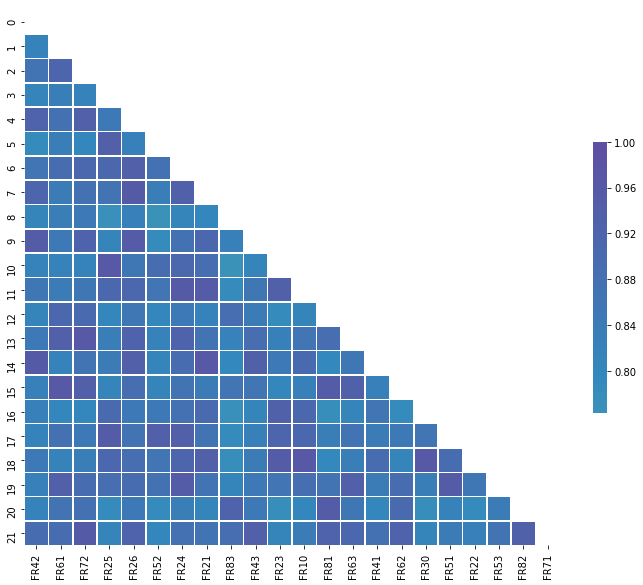

In [19]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Generate a custom diverging colormap
#cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, center=0, square=True, cmap='Spectral', linewidths=.5, cbar_kws={"shrink": .5}) #annot=True

In [20]:
df.groupBy("month").agg(mean('FR10').alias('avg solar efficiency'), count('FR10')).sort('month', ascending=True).show()

+-----+--------------------+-----------+
|month|avg solar efficiency|count(FR10)|
+-----+--------------------+-----------+
|    1| 0.05524854435483876|      22320|
|    2| 0.08560517365210546|      20328|
|    3| 0.13130328494623653|      22320|
|    4| 0.17104060787037043|      21600|
|    5|  0.1845260022401434|      22320|
|    6| 0.19233888518518516|      21600|
|    7| 0.19056154928315402|      22320|
|    8|  0.1819541321684587|      22320|
|    9| 0.15292063287037036|      21600|
|   10| 0.10511433691756275|      22320|
|   11| 0.06809282546296297|      21600|
|   12| 0.04891136469534048|      22320|
+-----+--------------------+-----------+



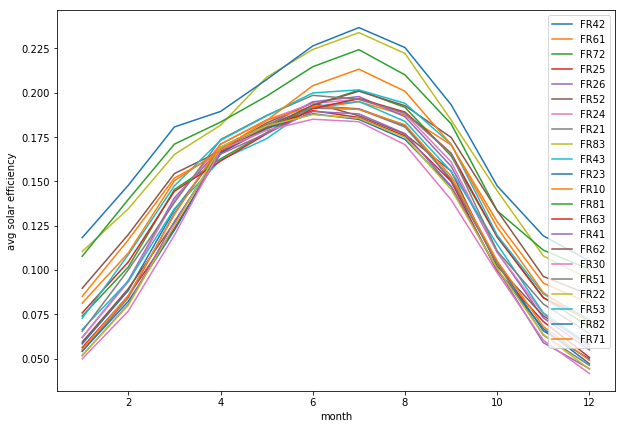

In [21]:
plt.figure(figsize=(10, 7))
for c in df.columns:
    if c not in ['date_time', 'month', 'day_of_year', 'hour']:
        temp_df = df.groupBy("month").agg(mean(c).alias('avg solar efficiency'))
        sns.lineplot(x="month", y="avg solar efficiency", data=temp_df.toPandas(), label=c)
plt.show()

In [22]:
df.groupBy("hour").agg(mean('FR10').alias('avg solar efficiency'), count('FR10')).sort('hour', ascending=True).show(24)

+----+--------------------+-----------+
|hour|avg solar efficiency|count(FR10)|
+----+--------------------+-----------+
|   0|                 0.0|      10957|
|   1|                 0.0|      10957|
|   2|                 0.0|      10957|
|   3|                 0.0|      10957|
|   4|3.606552888564386...|      10957|
|   5|0.004788690334945695|      10957|
|   6|0.029255778954093294|      10957|
|   7| 0.10150853974628092|      10957|
|   8| 0.20717653281007584|      10957|
|   9| 0.31310120105868405|      10957|
|  10| 0.37807000730126866|      10957|
|  11|  0.4175870010039244|      10957|
|  12|  0.4211149110157888|      10957|
|  13|  0.3987946728119013|      10957|
|  14| 0.34350144656384035|      10957|
|  15| 0.27063141735876617|      10957|
|  16|  0.1663934708405586|      10957|
|  17| 0.06960151775120929|      10957|
|  18|0.014985195765264213|      10957|
|  19|0.002810180706397738|      10957|
|  20|                 0.0|      10957|
|  21|                 0.0|      10957|


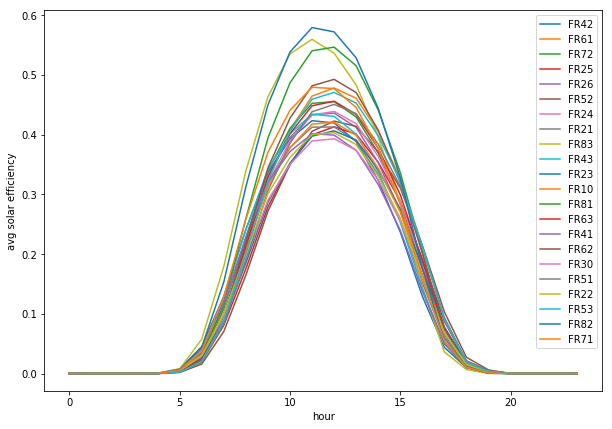

In [23]:
plt.figure(figsize=(10, 7))
for c in df.columns:
    if c not in ['date_time', 'month', 'day_of_year', 'hour']:
        temp_df = df.groupBy("hour").agg(mean(c).alias('avg solar efficiency'))
        sns.lineplot(x="hour", y="avg solar efficiency", data=temp_df.toPandas(), label=c)
plt.show()

In [31]:
df = df.withColumn("year", year(df.date_time).alias('year'))
df.groupBy("year").count().orderBy('year').show(30)

+----+-----+
|year|count|
+----+-----+
|1986| 8760|
|1987| 8760|
|1988| 8784|
|1989| 8760|
|1990| 8760|
|1991| 8760|
|1992| 8784|
|1993| 8760|
|1994| 8760|
|1995| 8760|
|1996| 8784|
|1997| 8760|
|1998| 8760|
|1999| 8760|
|2000| 8784|
|2001| 8760|
|2002| 8760|
|2003| 8760|
|2004| 8784|
|2005| 8760|
|2006| 8760|
|2007| 8760|
|2008| 8784|
|2009| 8760|
|2010| 8760|
|2011| 8760|
|2012| 8784|
|2013| 8760|
|2014| 8760|
|2015| 8760|
+----+-----+



In [32]:
temp_df = df.filter(df.year > 2006)

In [33]:
temp_df.show()

KeyboardInterrupt: 

In [ ]:
temp_df = df[df.year > 2016]

In [ ]:
temp_df.show()

In [ ]:
plt.figure(figsize=(14, 9))
sns.lineplot(x = df_solar_co.time, y = df_solar_co['FR'])

---

# 3. Predictions with various ML models